In [26]:

# Import file
input_path = 'C:/Users/candrews/Documents/GitHub/ethnicity-short-data-report/output/data/input.feather'

# Definitions
definitions = ['ethnicity_16', 'ethnicity_new_16', 'ethnicity_primis_16']

# Code dictionary
code_dict = {
    'imd': {0: 'Unknown', 100: '1 Most deprived', 200: '2', 300: '3', 400: '4', 500: '5 Least deprived'},
    'ethnicity_16': {1:'White_British',2:'White_Irish',3:'Other_White',4:'White_and_Black_Caribbean',5:'White_and_Black_African',6:'White_and_Asian',7:'Other_Mixed',8:'Indian',9:'Pakistani',10:'Bangladeshi',11:'Other_Asian',12:'Caribbean',13:'African',14:'Other_Black',15:'Chinese',16:'Any_other_ethnic_group'},
    'ethnicity_new_16': {1:'White_British',2:'White_Irish',3:'Other_White',4:'White_and_Black_Caribbean',5:'White_and_Black_African',6:'White_and_Asian',7:'Other_Mixed',8:'Indian',9:'Pakistani',10:'Bangladeshi',11:'Other_Asian',12:'Caribbean',13:'African',14:'Other_Black',15:'Chinese',16:'Any_other_ethnic_group'},
    'ethnicity_primis_16':  {1:'White_British',2:'White_Irish',3:'Other_White',4:'White_and_Black_Caribbean',5:'White_and_Black_African',6:'White_and_Asian',7:'Other_Mixed',8:'Indian',9:'Pakistani',10:'Bangladeshi',11:'Other_Asian',12:'Caribbean',13:'African',14:'Other_Black',15:'Chinese',16:'Any_other_ethnic_group'},
}

# Other variables to include
other_vars = ['White_British','White_Irish','Other_White','White_and_Black_Caribbean','White_and_Black_African','White_and_Asian','Other_Mixed','Indian','Pakistani','Bangladeshi','Other_Asian','Caribbean','African','Other_Black','Chinese','Any_other_ethnic_group']
other_vars_combined = [x+'_'+y for x in definitions for y in other_vars]

# Dates
dates = False
date_min = ''
date_max = ''
time_delta = ''

# Min/max range
min_range = 4
max_range = 200

# Null value – could be multiple values in a list [0,'0',NA]
null = [0,"0"]

# Covariates
demographic_covariates = ['age_band', 'sex', 'region', 'imd']
clinical_covariates = ['dementia', 'diabetes', 'hypertension', 'learning_disability']

# Output filepath
output_path = 'phenotype_validation_ethnicity/16'


In [58]:
import datetime
import itertools
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
import seaborn as sns

#from ebmdatalab import charts
from functools import reduce
from matplotlib import pyplot as plt


def redact_round_table(df_in):
    """Redacts counts <= 5 and rounds counts to nearest 5"""
    df_out = df_in.where(df_in > 5, np.nan).apply(lambda x: 5 * round(x/5))
    return df_out

def import_clean(input_path, definitions, other_vars, demographic_covariates, 
                 clinical_covariates, null, date_min, date_max, 
                 time_delta, output_path, code_dict='', dates=False):
    # Import
    df_import = pd.read_feather(input_path)
    # Dates
    if dates==True:
        date_vars = [definition+'_date' for definition in definitions]
        # Create variable that captures difference in measurement dates
        date_diff_vars = []
        # Define start and end dates
        start_date = datetime.datetime.strptime(date_min, '%Y-%m-%d')
        end_date = datetime.datetime.strptime(date_max, '%Y-%m-%d')
        for definition in definitions:
            # Remove OpenSAFELY null dates 
            df_import.loc[df_import[definition+'_date'] == '1900-01-01', definition+'_date'] = np.nan
            # Limit to period of interest             
            df_import[definition+'_date'] = pd.to_datetime(df_import[definition+'_date'])
            df_import.loc[df_import[definition+'_date'] < start_date, definition+'_date'] = np.nan
            df_import.loc[df_import[definition+'_date'] > end_date, definition+'_date'] = np.nan
            # Remove the measurement if outside the date parameters
            df_import.loc[df_import[definition+'_date'].isna(), definition] = np.nan
            df_import 
            # Create difference between measurement dates
            df_import[definition+'_date'] = df_import[definition+'_date'].dt.to_period(time_delta).dt.to_timestamp()
            df_import = df_import.sort_values(by=['patient_id',definition+'_date'])
            df_import['date_diff_' + definition] = round(df_import.groupby('patient_id')[definition+'_date'].diff() / np.timedelta64(1, time_delta))
            date_diff_vars.append('date_diff_' + definition)
    else: 
        date_vars = []
        date_diff_vars = []
    # Codes
    if code_dict!='':
        for key in code_dict:
            df_import[key] = df_import[key].astype(float)
            df_import[key] = df_import[key].replace(code_dict[key])
    # Subset to relevant columns
    df_clean = df_import[['patient_id'] + definitions + other_vars + date_vars + date_diff_vars + demographic_covariates + clinical_covariates]
    # Limit to relevant date range
    df_clean = df_clean.sort_values(by='patient_id').reset_index(drop=True)
    # Set null values to nan
    for definition in definitions: 
        df_clean.loc[df_clean[definition].isin(null), definition] = np.nan
     # Create order for categorical variables
    for group in demographic_covariates + clinical_covariates:
        if df_clean[group].dtype.name == 'category':
            li_order = sorted(df_clean[group].dropna().unique().tolist())
            df_clean[group] = df_clean[group].cat.reorder_categories(li_order, ordered=True)
    # Mark patients with value filled/missing for each definition
    li_filled = []
    for definition in definitions:
        df_fill = pd.DataFrame(df_clean.groupby("patient_id")[definition].any().astype('int')).rename(
            columns={definition:definition+'_filled'}
        )
        df_fill[definition+'_missing'] = 1-df_fill[definition+'_filled']
        li_filled.append(df_fill)

    df_filled = pd.concat(li_filled, axis=1)
    # Remove list from memory
    del li_filled  
    df_clean = df_clean.merge(df_filled, on='patient_id')
    
    # Flag all filled/all missing
    li_col_filled = [col for col in df_clean.columns if col.endswith('_filled')]
    li_col_missing = [col for col in df_clean.columns if col.endswith('_missing')]
    df_clean['all_filled'] = (df_clean[li_col_filled].sum(axis=1) == len(definitions)).astype(int)
    df_clean['all_missing'] = (df_clean[li_col_missing].sum(axis=1) == len(definitions)).astype(int)
    
    # Check whether output paths exist or not, create if missing
    path_tables = f'output/{output_path}/tables'
    path_figures = f'output/{output_path}/figures'
    li_filepaths = [path_tables, path_figures]

    for filepath in li_filepaths:
        exists = os.path.exists(filepath)
        if not exists:
            os.makedirs(filepath)

    return df_clean

def patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates, output_path, categories=False, missing=False):
    suffix = '_filled'
    subgroup = 'with records'
    overlap = 'all_filled'
    if missing == True:
        suffix = '_missing'
        subgroup = 'missing records'
        overlap = 'all_missing'
    if categories == True:
        li_cat_def = []
        for definition in definitions:
            li_cat = df_clean[definition].dropna().astype(str).sort_values().unique().tolist()
            for x in li_cat:
                df_clean.loc[df_clean[definition] == x, f'{definition}_{x}_filled'] = 1 
                li_cat_def.append(f'{definition}_{x}')
        definitions = li_cat_def

    # All with measurement
    li_filled = []
    for definition in definitions:
        df_temp = df_clean[['patient_id', definition+suffix]].drop_duplicates().dropna().set_index('patient_id')
        li_filled.append(df_temp)

    df_temp = df_clean[['patient_id', overlap]].drop_duplicates().dropna().set_index('patient_id')
    li_filled.append(df_temp)
    
    df_temp2 = pd.concat(li_filled, axis=1)
    df_temp2['population'] = 1
    # Remove list from memory
    del li_filled
    df_all = pd.DataFrame(df_temp2.sum()).T
    df_all['group'],df_all['subgroup'] = ['all',subgroup]
    df_all = df_all.set_index(['group','subgroup'])
    
    # By group
    li_group = []
    for group in demographic_covariates + clinical_covariates:
        li_filled_group = []
        for definition in definitions:
            df_temp = df_clean[['patient_id', definition+suffix, group]].drop_duplicates().dropna().reset_index(drop=True)
            li_filled_group.append(df_temp)
            
        df_temp = df_clean[['patient_id', overlap, group]].drop_duplicates().dropna().reset_index(drop=True)
        li_filled_group.append(df_temp)
        
        df_reduce = reduce(lambda df1, df2: pd.merge(df1, df2,on=['patient_id',group],how='outer'), li_filled_group)
        df_reduce['population'] = 1
        # Remove list from memory
        del li_filled_group 
        df_reduce2 = df_reduce.sort_values(by=group).drop(columns=['patient_id']).groupby(group).sum().reset_index()
        df_reduce2['group'] = group
        df_reduce2 = df_reduce2.rename(columns={group:'subgroup'})
        li_group.append(df_reduce2)
    df_all_group = pd.concat(li_group, axis=0, ignore_index=True).set_index(['group','subgroup'])
    # Remove list from memory
    del li_group 
    
    # Redact
    df_append = redact_round_table(df_all.append(df_all_group))
        
    # Create percentage columns 
    for definition in definitions:
        df_append[definition+'_pct'] = round((df_append[definition+suffix].div(df_append['population']))*100,1)
    df_append[overlap+'_pct'] = round((df_append[overlap].div(df_append['population']))*100,1)

    # Final redaction step
    df_append = df_append.where(~df_append.isna(), '-')  

    # Combine count and percentage columns
    for definition in definitions:
        df_append[definition] = df_append[definition+suffix].astype(str) + " (" + df_append[definition+'_pct'].astype(str) + ")" 
        df_append = df_append.drop(columns=[definition+suffix,definition+'_pct'])
    df_append[overlap] = df_append[overlap].astype(str) + " (" + df_append[overlap+'_pct'].astype(str) + ")" 
    df_append = df_append.drop(columns=[overlap+'_pct'])
    
    # Column order
    li_col_order = []
    for definition in definitions:
        li_col_order.append(definition)
    li_col_order.append(overlap)
    li_col_order.append('population')

    df_all_redact = df_append[li_col_order]

    if categories == False:
        df_all_redact.to_csv(f'output/{output_path}/tables/patient_counts{suffix}.csv')
    if categories == True:
        df_all_redact.to_csv(f'output/{output_path}/tables/patient_counts_by_categories{suffix}.csv')

def display_heatmap(df_clean, definitions, output_path):
    # All with measurement
    li_filled = []
    for definition in definitions:
        df_temp = df_clean[['patient_id']].drop_duplicates().set_index('patient_id')
        df_temp[definition+'_filled'] = 1
        df_temp = df_clean[['patient_id', definition+'_filled']].drop_duplicates().dropna().set_index('patient_id')
        li_filled.append(df_temp)

    # Prepare data for heatmap input
    df_temp2 = pd.concat(li_filled, axis=1)
    # Remove list from memory
    del li_filled 
    df_transform = df_temp2.replace(np.nan,0)
    df_dot = redact_round_table(df_transform.T.dot(df_transform))
    
    # Create mask to eliminate duplicates in heatmap
    mask = np.triu(np.ones_like(df_dot))
    np.fill_diagonal(mask[::1], 0)

    # Draw the heatmap with the mask
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(df_dot, annot=True, mask=mask, fmt='g', cmap="YlGnBu", vmin=0)
    #plt.show()
    plt.savefig(f'output/{output_path}/figures/heatmap.png')

def records_over_time(df_clean, definitions, demographic_covariates, clinical_covariates, output_path):
    li_df = []
    for definition in definitions:
        df_grouped = df_clean[[definition+'_date',definition]].groupby(definition+'_date').count().reset_index().rename(columns={definition+'_date':'date'}).set_index('date')
        li_df.append(redact_round_table(df_grouped))
    df_all_time = pd.concat(li_df).stack().reset_index().rename(columns={'level_1':'variable',0:'value'})
    # Remove list from memory
    del li_df 
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.autofmt_xdate()
    sns.lineplot(x = 'date', y = 'value', hue='variable', data = df_all_time, ax=ax).set_title('New records by month')
    ax.legend().set_title('')
    plt.savefig(f'output/{output_path}/figures/records_over_time.png')

    for group in demographic_covariates + clinical_covariates:
        for definition in definitions:
            df_grouped = df_clean[[definition+'_date',definition,group]].groupby(
                                  [definition+'_date',group]).count().reset_index().rename(columns={definition+'_date':'date'}).set_index(['date', group])
            df_time=redact_round_table(df_grouped).reset_index()
            fig, ax = plt.subplots(figsize=(12, 8))
            fig.autofmt_xdate()
            sns.lineplot(x = 'date', y = definition, hue=group, data = df_time, ax=ax).set_title(f'{definition} recorded by {group} and month')
            ax.legend().set_title('')
            plt.savefig(f'output/{output_path}/figures/records_over_time_{definition}_{group}.png')
            
def report_distribution(df_occ, definitions, num_definitions, output_path, group=''):
    """
    Plots histogram or boxplots of distribution
    """
    if group == '':
        if num_definitions == 1:
            for definition in definitions: 

                avg_value = pd.DataFrame(
                    df_occ[definition].agg(
                        ['mean','count']
                    )
                )
                if avg_value.loc['count'][0] > 6:
                    avg_value.loc['count'][0] = 5 * round(avg_value.loc['count'][0]/5)
                    print(f'Average {definition}:\n')
                    #display(avg_value)
                    avg_value.to_csv(f'output/{output_path}/tables/avg_value_{definition}.csv')
                    fig, ax = plt.subplots(figsize=(12, 8))
                    hist_data = df_occ[definition].loc[~df_occ[definition].isna()]
                    plt.hist(hist_data, bins=np.arange(min(hist_data), max(hist_data)))
                    plt.title('Distribution of ' + definition)
                    #plt.show()
                    plt.savefig(f'output/{output_path}/figures/distribution.png')
                else:
                    print('Table and plot redacted due to low counts.')
                    
        else:
            df_bp = df_occ[definitions]
            avg = pd.DataFrame(df_bp.mean(),columns=['mean'])
            ct = pd.DataFrame(df_bp.count(),columns=['count'])
            avg_value = avg.merge(ct, left_index=True, right_index=True)
            # Redact and round values
            avg_value['count'] = avg_value['count'].where(
                avg_value['count'] > 5, np.nan).apply(lambda x: 5 * round(x/5) if ~np.isnan(x) else x)
            print('Averages:\n')
            #display(avg_value)
            avg_value.to_csv(f'output/{output_path}/tables/avg_value.csv')
            fig, ax = plt.subplots(figsize=(12, 8))
            sns.boxplot(data=df_bp,showfliers = False)
            plt.title("Distributions of values")
            #plt.show()
            plt.savefig(f'output/{output_path}/figures/distribution.png')
    else:
        if num_definitions == 1:
            for definition in definitions: 
                df_bp = df_occ[[group]+ [definition]]
                avg_value = df_bp.groupby(group)[definition].agg(
                    ['mean', 'count']
                )
                # Redact and round values
                avg_value['count'] = avg_value['count'].where(
                    avg_value['count'] > 5, np.nan).apply(lambda x: 5 * round(x/5) if ~np.isnan(x) else x)
                avg_value.loc[avg_value['count'].isna(), ['count','mean']] = ['-','-']
                print(f'Averages by {group}:\n')
                #display(avg_value)    
                avg_value.to_csv(f'output/{output_path}/tables/avg_value_{definition}_{group}.csv')
                null_index = avg_value[avg_value['count'] == '-'].index.tolist()
                fig, ax = plt.subplots(figsize=(12, 8))
                sns.boxplot(x=group, y=definition, data=df_bp.loc[~df_bp[group].isin(null_index)], showfliers=False)
                plt.title(f"Distributions by {group}")
                #plt.show()
                plt.savefig(f'output/{output_path}/figures/distribution_{group}.png')
        else:
            if df_occ[group].dtype == 'bool':
                df_occ[group] = df_occ[group].apply(lambda x: str(x))
            df_occ = df_occ.loc[~df_occ[group].isna()] # Drop nan categories
            df_bp = df_occ[[group] + definitions]
            avg = df_bp.groupby(group).mean().add_prefix("avg_")
            ct = df_bp.groupby(group).count().add_prefix("ct_")
            avg_value = avg.merge(ct, left_on=group, right_on=group)
            for definition in definitions:
                # Redact and round values
                avg_value['ct_'+definition] = avg_value['ct_'+definition].where(
                    avg_value['ct_'+definition] > 5, np.nan).apply(lambda x: 5 * round(x/5) if ~np.isnan(x) else x)
                avg_value.loc[avg_value['ct_'+definition].isna(), 
                                    ['ct_'+definition,'avg_'+definition]] = ['-','-']
            print(f'Averages by {group}:\n')
            #display(avg_value)
            avg_value.to_csv(f'output/{output_path}/tables/avg_value_{group}.csv')
            for definition in definitions:
                null_index = []
                null_index = avg_value[avg_value['ct_'+definition] == '-'].index.tolist()
                df_bp.loc[df_bp[group].isin(null_index),definition] = np.nan
            fig, ax = plt.subplots(figsize=(12, 8))
            df_plot = df_bp.melt(id_vars=group, value_vars=definitions)
            sns.boxplot(x=group, y='value', hue='variable', data=df_plot, showfliers=False)
            plt.title(f'Distributions by {group}')
            #plt.show()
            plt.savefig(f'output/{output_path}/figures/distribution_{group}.png')
            
def report_out_of_range(df_occ, definitions, min_range, max_range, num_definitions, null, output_path, group=''):
    """
    Reports number of measurements outside of defined range
    """
    
    def q25(x):
        return x.quantile(0.25)
    def q75(x):
        return x.quantile(0.75)
    
    li_dfs = []
    
    df_oor = df_occ
    for definition in definitions: 
        df_oor.loc[(df_oor[definition] < min_range) | (df_oor[definition] > max_range), "out_of_range_"+definition] = 1
        # Make definitions null if not out of range or empty
        df_oor["oor_" + definition] = df_oor[definition]
        df_oor.loc[(df_oor["out_of_range_"+definition] != 1) | (df_oor[definition].isin(null)), "oor_" + definition] = np.nan
        if group == '':
            try:
                df_out = df_oor.agg(
                                    count = ("oor_" + definition, 'count'),
                                    mean  = ("oor_" + definition, 'mean'),
                                    pct25 = ("oor_" + definition,q25),
                                    pct75 = ("oor_" + definition,q75),
                                    )
            except:
                df_out = pd.DataFrame([['count', 0],['mean',np.nan],
                                       ['pct25',np.nan],['pct75',np.nan]], 
                                      columns=['index',"oor_" + definition]).set_index('index')
            if df_out.loc['count']["oor_" + definition] > 6:
                df_out.loc['count']["oor_" + definition] = 5 * round(df_out.loc['count']["oor_" + definition]/5)
            else:
                df_out["oor_" + definition] = '-'
        else:
            df_out = df_oor.groupby(group)["oor_" + definition].agg(
                                                [('count', 'count'),
                                                 ('mean', 'mean'),
                                                 ('pct25', q25),
                                                 ('pct75', q75)]
                                              ).add_suffix("_"+definition)
            df_out.loc[df_out["count_" + definition] > 5, "count_" + definition] = 5 * round(df_out["count_" + definition]/5)
            df_out.loc[df_out["count_" + definition] < 6, 
                       ["count_" + definition, "mean_" + definition,
                       "pct25_" + definition, "pct75_" + definition]] = ['-','-','-','-']
        li_dfs.append(df_out)    
    
    if num_definitions == 1:    
        #display(df_out)
        df_out.to_csv(f'output/{output_path}/tables/out_of_range.csv')
        # Remove list from memory
        del li_dfs 
        if group == '': 
            if df_out["oor_" + definition]['count'] != '-':
                df_plot = df_oor["oor_" + definition]
                fig, ax = plt.subplots(figsize=(12, 8))
                plt.hist(df_plot)
                plt.title('Distribution of out of range ' + definition)
                #plt.show()
                plt.savefig(f'output/{output_path}/figures/out_of_range.png')
            else:
                print('Plot redacted due to low counts.')
        else:
            df_oor = df_oor.loc[~df_oor[group].isna()]
            for definition in definitions: 
                null_index = df_out[df_out['count_'+definition] == '-'].index.tolist()
                df_oor.loc[df_oor[group].isin(null_index),'oor_'+definition] = np.nan
                df_bp = df_oor[[group]+ ["oor_" + definition]]
                if df_bp["oor_" + definition].sum() > 0:
                    fig, ax = plt.subplots(figsize=(12, 8))
                    sns.boxplot(x=group, y="oor_" + definition, data=df_bp, showfliers=False)
                    plt.title(f"Distribution of out of range values by {group}")
                    plt.show()
                    plt.savefig(f'output/{output_path}/figures/out_of_range_{group}.png')
                else:
                    print('Plot redacted due to low counts.')
    else:
        df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), li_dfs)
        # Remove list from memory
        del li_dfs 
        #display(df_merged)
        if group == '':    
            df_merged.to_csv(f'output/{output_path}/tables/out_of_range.csv')
            cols = ["oor_" + definition for definition in definitions]
            df_bp = df_oor[cols]
            if df_merged["oor_" + definition]['count'] == '-':
                df_bp["oor_" + definition] = np.nan
            try:
                fig, ax = plt.subplots(figsize=(12, 8))
                sns.boxplot(data=df_bp, showfliers=False)
                plt.title('Distribution of out of range values')
                #plt.show()
                plt.savefig(f'output/{output_path}/figures/out_of_range.png')
            except: 
                print('Plot redacted due to low counts.')
        else:
            df_merged.to_csv(f'output/{output_path}/tables/out_of_range_{group}.csv')
            df_oor = df_oor.loc[~df_oor[group].isna()]
            for definition in definitions: 
                null_index = df_merged[df_merged['count_'+definition] == '-'].index.tolist()
                df_oor.loc[df_oor[group].isin(null_index),'oor_'+definition] = np.nan
            if df_oor[group].dtype == 'bool':
                df_oor[group] = df_oor[group].apply(lambda x: str(x))
            cols = ["oor_" + definition for definition in definitions]
            df_bp = df_oor[[group] + cols]
            df_plot = df_bp.melt(id_vars=group, value_vars=cols)
            if df_plot['value'].sum() > 0:
                fig, ax = plt.subplots(figsize=(12, 8))
                sns.boxplot(x=group, y='value', hue='variable', data=df_plot, showfliers=False)
                plt.title(f'Distribution of out of range values by {group}')
                #plt.show()
                plt.savefig(f'output/{output_path}/figures/out_of_range_{group}.png')
            else: 
                print('Plot redacted due to low counts.')
        
def report_update_frequency(df_occ, definitions, time_delta, num_definitions, output_path, group=''):
    """
    Plots histogram or boxplot of update frequency and reports average update frequency
    """
    if group == '':
        if num_definitions == 1:
            for definition in definitions: 
                avg_update_freq = df_occ.agg(
                    avg_diff = (f'date_diff_{definition}', 'mean'),
                    count = (f'date_diff_{definition}' , 'count')
                )
                if avg_update_freq.loc['count'][0] > 6:
                    avg_update_freq.loc['count'][0] = 5 * round(avg_update_freq.loc['count'][0]/5)
                    print(f'Average update frequency of {definition} by {time_delta}:\n')
                    #display(avg_update_freq)
                    avg_update_freq.to_csv(f'output/{output_path}/tables/avg_update_frequency_{definition}.csv')
                    fig, ax = plt.subplots(figsize=(12, 8))
                    plt.hist(df_occ['date_diff_' + definition])
                    plt.title('Update frequency of ' + definition + f" by {time_delta}")
                    #plt.show()
                    plt.savefig(f'output/{output_path}/figures/avg_update_frequency_{definition}.png')
                else:
                    print('Table and plot redacted due to low counts.')
        else:
            cols = ['date_diff_' + x for x in definitions]
            df_bp = df_occ[cols]
            avg_update = pd.DataFrame(df_bp.mean(),columns=['avg_diff'])
            ct_update = pd.DataFrame(df_bp.count(),columns=['count'])
            avg_update_freq = avg_update.merge(ct_update, left_index=True, right_index=True)
            # Redact and round values
            avg_update_freq['count'] = avg_update_freq['count'].where(
                avg_update_freq['count'] > 5, np.nan).apply(lambda x: 5 * round(x/5) if ~np.isnan(x) else x)
            print(f'Average update frequency by {time_delta}:\n')
            #display(avg_update_freq)    
            avg_update_freq.to_csv(f'output/{output_path}/tables/avg_update_frequency.csv')
            fig, ax = plt.subplots(figsize=(12, 8))
            null_index = avg_update_freq[avg_update_freq['count'] == '-'].index.tolist()
            sns.boxplot(data=df_bp.drop(columns=null_index), showfliers=False)
            plt.title(f"Update frequency by {time_delta}")
            #plt.show()
            plt.savefig(f'output/{output_path}/figures/avg_update_frequency.png')
          
    else:
        if num_definitions == 1:
            for definition in definitions: 
                df_bp = df_occ[[group]+ ['date_diff_' + definition]]
                avg_update_freq = df_occ.groupby(group).agg(
                    avg_diff = ('date_diff_' + definition, 'mean'),
                    count = ('date_diff_' + definition, 'count')
                ).reset_index()
                # Redact and round values
                avg_update_freq['count'] = avg_update_freq['count'].where(
                    avg_update_freq['count'] > 5, np.nan).apply(lambda x: 5 * round(x/5) if ~np.isnan(x) else x)
                avg_update_freq.loc[avg_update_freq['count'].isna(), ['count','avg_diff']] = ['-','-']
                print(f'Average update frequency by {group} and {time_delta}:\n')
                #display(avg_update_freq)    
                avg_update_freq.to_csv(f'output/{output_path}/tables/avg_update_frequency_{definition}.csv')
                null_index = avg_update_freq[avg_update_freq['count'] == '-'].index.tolist()
                fig, ax = plt.subplots(figsize=(12, 8))
                sns.boxplot(x=group, y='date_diff_'+definition, data=df_bp.loc[~df_bp[group].isin(null_index)].sort_index(), showfliers=False)
                plt.title(f"Update frequency by {group} and {time_delta}")
                #plt.show()
                plt.savefig(f'output/{output_path}/figures/avg_update_frequency_{definition}.png')
        else:
            if df_occ[group].dtype == 'bool':
                df_occ[group] = df_occ[group].apply(lambda x: str(x))
            df_occ = df_occ.loc[~df_occ[group].isna()] # Drop nan categories
            cols = ['date_diff_' + x for x in definitions]
            df_sub = df_occ[[group] + cols]
            avg_update = df_sub.groupby(group).mean().add_prefix("avg_")
            ct_update = df_sub.groupby(group).count().add_prefix("ct_")
            avg_update_freq = avg_update.merge(ct_update, left_on=group, right_on=group).sort_index()
            for definition in definitions:
                # Redact and round values
                avg_update_freq['ct_date_diff_'+definition] = avg_update_freq['ct_date_diff_'+definition].where(
                    avg_update_freq['ct_date_diff_'+definition] > 5, np.nan).apply(lambda x: 5 * round(x/5) if ~np.isnan(x) else x)
                avg_update_freq.loc[avg_update_freq['ct_date_diff_'+definition].isna(), 
                                    ['ct_date_diff_'+definition,'avg_date_diff_'+definition]] = ['-','-']
            # Sort by index
            print(f'Average update frequencies by {time_delta}:\n')
            #display(avg_update_freq)
            avg_update_freq.to_csv(f'output/{output_path}/tables/avg_update_frequency_{group}.csv')
            for definition in definitions:
                null_index = []
                null_index = avg_update_freq[avg_update_freq['ct_date_diff_'+definition] == '-'].index.tolist()
                df_sub.loc[df_sub[group].isin(null_index),'date_diff_'+definition] = np.nan
            fig, ax = plt.subplots(figsize=(12, 8))
            df_plot = df_sub.melt(id_vars=group, value_vars=cols)
            sns.boxplot(x=group, y='value', hue='variable', data=df_plot, showfliers=False)
            plt.title(f'Update frequencies by {group} and {time_delta}')
            #plt.show()
            plt.savefig(f'output/{output_path}/figures/avg_update_frequency_{group}.png')
            
def latest_common_comparison(df_clean, definitions, other_vars, output_path):
    for definition in definitions:
        vars = [s for s in other_vars if s.startswith(definition)]
        df_subset = df_clean.loc[~df_clean[definition].isna()]
        df_subset=df_subset[[definition]+vars].set_index(definition)

        df_subset2 = df_subset.where(df_subset.eq(df_subset.max(1),axis=0))
        df_subset_3 = df_subset2.notnull().astype('int').reset_index()
        df_sum = redact_round_table(df_subset_3.groupby(definition).sum())
  #      df_sum = df_sum.where(~df_sum.isna(), '-')

        df_counts = pd.DataFrame(np.diagonal(df_sum),index=df_sum.index,columns=[f'matching (n={np.diagonal(df_sum).sum()})'])

        df_sum2 = df_sum.copy(deep=True)
        np.fill_diagonal(df_sum2.values, 0)
        df_diag = pd.DataFrame(df_sum2.sum(axis=1), columns=[f'not_matching (n={df_sum2.sum(axis=1).sum()})'])
        df_out = df_counts.merge(df_diag,right_index=True,left_index=True)
        #display(df_out)
        df_out.to_csv(f'output/{output_path}/tables/latest_common_simple_{definition}.csv')

        df_sum = redact_round_table(df_subset_3.groupby(definition).sum())     

        for col in df_sum.columns:
            df_sum = df_sum.rename(columns = {col:f'{col} (n={df_sum[col].sum()})'})
        #display(df_sum)
        df_sum = df_sum.where(~df_sum.isna(), '-')
        df_sum.to_csv(f'output/{output_path}/tables/latest_common_expanded_{definition}.csv')
            
def state_change(df_clean, definitions, other_vars, output_path):
    for definition in definitions:
        vars = [s for s in other_vars if s.startswith(definition)]
        df_subset = df_clean[
            [definition]+vars
        ].replace(0,np.nan).set_index(definition).reset_index()
        df_subset['n'] = 1
        # Count
        df_subset2 = df_subset.loc[~df_subset[definition].isna()]
        df_subset3 = redact_round_table(df_subset2.groupby(definition).count()).reset_index()
        # Set index
        df_subset3['index'] = df_subset3[definition].astype(str) + " (n = " + df_subset3['n'].astype(int).astype(str) + ")"
        df_out = df_subset3.drop(columns=[definition,'n']).rename(columns = {'index':definition}).set_index(definition)
        # Null out the diagonal
        np.fill_diagonal(df_out.values, np.nan)
        df_out = df_out.where(~df_out.isna(), '-')
    
        #display(df_out)
        df_out.to_csv(f'output/{output_path}/tables/state_change_{definition}.csv')

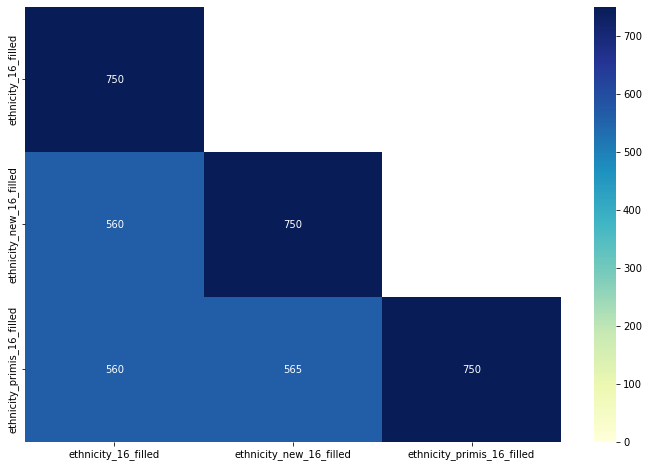

In [59]:

def main():
    # combine defintions and other_vars  
    df_clean = import_clean(input_path, definitions, other_vars_combined, demographic_covariates, 
                        clinical_covariates, null, date_min, date_max, 
                        time_delta, output_path, code_dict, dates)
    # Count patients with records
    patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates, output_path)
    # Count patients without records
    patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates, output_path, missing=True)
    # Count patients by categories 
    patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates, output_path, categories=True)
    # Generate heatmap of overlapping definitions
    display_heatmap(df_clean, definitions, output_path)
    # Latest v most common
    latest_common_comparison(df_clean, definitions, other_vars_combined, output_path)
    # State change
    state_change(df_clean, definitions, other_vars_combined, output_path)
    
########################## DO NOT EDIT – RUNS SCRIPT ##############################

if __name__ == "__main__":
    main()

### Count by Category

In [ ]:
df_patient_cat_counts = pd.read_csv(f'../output/{output_path}/tables/patient_counts_by_categories_filled.csv').set_index(['group','subgroup'])
display(df_patient_cat_counts)

### Overlapping Definitions
Idea: Use an upset plot

In [ ]:
display(Image(f"../output/{output_path}/figures/heatmap.png"))

### Latest vs. Most Common

In [ ]:
for definition in definitions:
    df_simple = pd.read_csv(f'../output/{output_path}/tables/latest_common_simple_{definition}.csv').set_index(definition)
    df_expanded = pd.read_csv(f'../output/{output_path}/tables/latest_common_expanded_{definition}.csv').set_index(definition)
    display(df_simple)
    display(df_expanded)

### State Change

In [ ]:
for definition in definitions:
    df_state_change = pd.read_csv(f'../output/{output_path}/tables/state_change_{definition}.csv').set_index(definition)
    display(df_state_change)